# Capstone Project Part 6: Text Tokenizing

**Authur:** Kate Meredith 

**Date:** September-November 2022

**Notebook #**: 6 of

## Background

**Source:** Data was collected from [CoffeeReview.com](https://www.coffeereview.com/). See prior notebooks for details on scraping, cleaning and compilation. This notebook focuses on tokenizing the review text.

In [547]:
#Importing libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tempfile import mkdtemp

### References

- Used this [article](https://stackoverflow.com/questions/37080612/pandas-dataframe-filter-regex) for searching for specific text in columns

### Importing and previewing data

In [548]:
coffee = pd.read_csv('coffee.csv')

In [549]:
coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6557 entries, 0 to 6556
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   coffee_name    6557 non-null   object 
 1   roaster_name   6557 non-null   object 
 2   month          6557 non-null   int64  
 3   year           6557 non-null   int64  
 4   bean_agtron    6557 non-null   int64  
 5   ground_agtron  6557 non-null   int64  
 6   aroma          6557 non-null   int64  
 7   acidity        6557 non-null   int64  
 8   body           6557 non-null   int64  
 9   flavor         6557 non-null   int64  
 10  aftertaste     6557 non-null   int64  
 11  roaster_lat    6557 non-null   float64
 12  roaster_lon    6557 non-null   float64
 13  origin_lat     6557 non-null   float64
 14  origin_lon     6557 non-null   float64
 15  p1             6557 non-null   object 
 16  p2             6557 non-null   object 
 17  p3             6557 non-null   object 
 18  overall_

In [550]:
coffee.shape

(6557, 19)

In [551]:
coffee.head()

,coffee_name,roaster_name,month,year,bean_agtron,ground_agtron,aroma,acidity,body,flavor,aftertaste,roaster_lat,roaster_lon,origin_lat,origin_lon,p1,p2,p3,overall_score
0,Colombia Cerro Azul Enano,Equator Coffees,10,2022,60,77,9,9,9,9,8,37.973535,-122.531087,4.099917,-72.908813,Blind Assessment: Elegantly fruit- and cocoa-t...,Notes: Produced at Finca Cerro Azul (also owne...,The Bottom Line: This rare Enano (dwarf Geish...,94
1,Peru Incahuasi,Press Coffee,10,2022,58,78,9,9,9,9,8,33.448437,-112.074141,-6.869970,-75.045851,"Blind Assessment: Gently fruit-toned, integrat...",Notes: Produced at Incahuasi Farm from trees o...,The Bottom Line: Laden with tropical fruit not...,94
2,Colombia Aponte’s Guardians,Press Coffee,10,2022,59,77,9,9,8,9,8,33.448437,-112.074141,4.099917,-72.908813,"Blind Assessment: Richly sweet, spice-toned. L...",Notes: Produced at Aponte Farm from an undiscl...,"The Bottom Line: A balanced, inviting washed C...",93
3,Nicaragua Flor de Dalia Natural,Equator Coffees,10,2022,62,78,8,8,9,9,8,37.973535,-122.531087,12.609016,-85.293691,"Blind Assessment: Gently fruit-forward, sweetl...",Notes: Produced by smallholding members of the...,"The Bottom Line: A refreshing, very sweet natu...",92
4,Ethiopia Bench Maji Geisha G1 Natural,Taster's Coffee,10,2022,65,81,9,9,8,9,8,25.072134,121.679919,10.211670,38.652120,"Blind Assessment: Gently sweet-tart, floral-to...",Notes: Produced from trees of the admired bota...,The Bottom Line: A quietly confident natural-p...,93


In [552]:
coffee.describe()

,month,year,bean_agtron,ground_agtron,aroma,acidity,body,flavor,aftertaste,roaster_lat,roaster_lon,origin_lat,origin_lon,overall_score
count,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000
mean,6.642062,2013.102181,52.229983,67.668598,8.360988,7.904224,8.086472,8.361598,7.795638,37.027419,-64.412448,10.198811,-12.161417,90.873723
std,3.437202,6.719059,8.411739,12.936090,0.927393,1.023060,0.871203,1.065692,0.874365,9.504209,81.708964,12.709097,68.848718,4.089739
min,1.000000,1997.000000,11.000000,12.000000,2.000000,1.000000,4.000000,1.000000,2.000000,-37.824425,-159.582761,-30.292848,-155.428370,60.000000
25%,4.000000,2008.000000,48.000000,60.000000,8.000000,8.000000,8.000000,8.000000,7.000000,32.840162,-117.423510,1.441968,-79.366697,90.000000
50%,7.000000,2014.000000,54.000000,71.000000,9.000000,8.000000,8.000000,9.000000,8.000000,39.049011,-89.383761,10.211670,7.540121,92.000000
75%,10.000000,2019.000000,58.000000,77.000000,9.000000,9.000000,9.000000,9.000000,8.000000,43.074761,-72.815099,13.800038,38.652120,93.000000
max,12.000000,2022.000000,91.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,64.837845,152.952215,52.380033,153.125616,98.000000


### Preprocessing

Before we create our X and y, there are some repeated text words that appear in `p1`, `p2`, and `p3`. In most reviews, these paragrapsh correspond to:

- p1: Blind Assessment
- p2: Notes
- p3: The Bottom Line OR Who Should Drink it

We'll first check to see if these paragraphs do contain the information we expect.

Checking the composition of paragraphs:

In [553]:
#see how many of p1 paragraphs reference which type of information
len(coffee.loc[coffee['p1'].str.contains(r'(Blind Assessment).*')])

/var/folders/jm/x73vvhpx2cd14qw0zx2ccfsc0000gn/T/ipykernel_8414/1218255241.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  len(coffee.loc[coffee['p1'].str.contains(r'(Blind Assessment).*')])


6557

In [554]:
#see how many of p2 paragraphs reference which type of information
len(coffee.loc[coffee['p2'].str.contains(r'(Notes).*')])

/var/folders/jm/x73vvhpx2cd14qw0zx2ccfsc0000gn/T/ipykernel_8414/3921903414.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  len(coffee.loc[coffee['p2'].str.contains(r'(Notes).*')])


6557

In [555]:
#see how many of p3 paragraphs reference which type of information
len(coffee.loc[coffee['p3'].str.contains(r'(The Bottom).*')])

/var/folders/jm/x73vvhpx2cd14qw0zx2ccfsc0000gn/T/ipykernel_8414/984657743.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  len(coffee.loc[coffee['p3'].str.contains(r'(The Bottom).*')])


2728

In [556]:
#see how many of p3 paragraphs reference which type of information
len(coffee.loc[coffee['p3'].str.contains(r'(Who Should).*')])

/var/folders/jm/x73vvhpx2cd14qw0zx2ccfsc0000gn/T/ipykernel_8414/2101417195.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  len(coffee.loc[coffee['p3'].str.contains(r'(Who Should).*')])


3777

As expected, paragraphs 1 and 2 contain consistent data, paragraph 3 is split. We'll need to remove "Blind Assessment", "The Bottom Line", "Who Should Drink it" and "Notes" from our bag of words as they appear in every review.

Getting rid of repeat words:

In [557]:
#splitting out paragraph review score labels
coffee[['ba','p1']] = coffee['p1'].str.split(":", n=1, expand=True)

In [558]:
#splitting out paragraph review score labels
coffee[['N','p2']] = coffee['p2'].str.split(":", n=1, expand=True)

In [559]:
#splitting out paragraph review score labels
coffee[['tbl','p3']] = coffee['p3'].str.split(":", n=1, expand=True)

In [560]:
#drop unneeded holding columns
coffee.drop(['ba', 'N', 'tbl'], axis=1, inplace=True)

In [561]:
#checking for nan
coffee.isna().sum()

coffee_name      0
roaster_name     0
month            0
year             0
bean_agtron      0
ground_agtron    0
aroma            0
acidity          0
body             0
flavor           0
aftertaste       0
roaster_lat      0
roaster_lon      0
origin_lat       0
origin_lon       0
p1               0
p2               0
p3               3
overall_score    0
dtype: int64

In [562]:
#drop rows missing value in overall_score column 
coffee.dropna(subset = ['p3'], inplace=True)

In [563]:
len(coffee)

6554

### Creating X and y

target = `overall_score`

In [564]:
X = coffee.drop('overall_score', axis = 1)

In [565]:
X.shape

(6554, 18)

In [566]:
y = coffee['overall_score']

In [567]:
y.shape

(6554,)

In [568]:
y.describe()

count    6554.000000
mean       90.872902
std         4.090446
min        60.000000
25%        90.000000
50%        92.000000
75%        93.000000
max        98.000000
Name: overall_score, dtype: float64

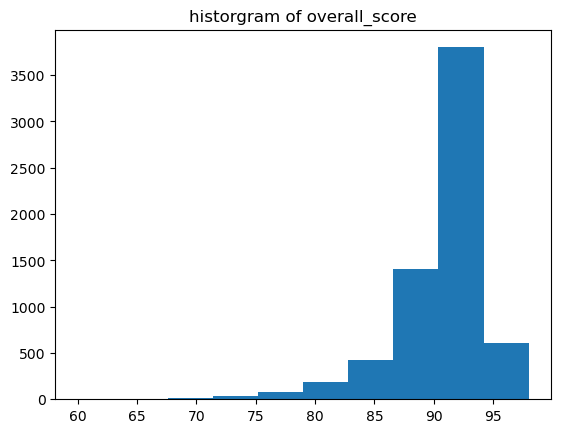

In [569]:
#plot y distribution
plt.figure()
plt.hist(coffee['overall_score'])
plt.title('historgram of overall_score')
plt.show()

In [570]:
#create train/test split, using 20% given dataset size

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [571]:
#create train/validate split, using 20% given dataset size

X_remain, X_val, y_remain, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [572]:
X_train.shape

(5243, 18)

In [573]:
X_remain.shape

(4194, 18)

In [574]:
X_val.shape

(1049, 18)

In [575]:
X_test.shape

(1311, 18)

In [576]:
y_train.shape

(5243,)

In [577]:
y_remain.shape

(4194,)

In [578]:
y_val.shape

(1049,)

In [579]:
y_test.shape

(1311,)

Do my train, val, test splits have similar distributions?

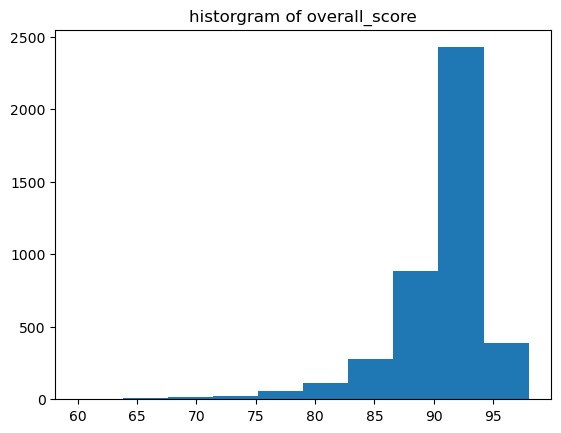

In [580]:
#plot y val distribution
plt.figure()
plt.hist(y_remain)
plt.title('historgram of overall_score')
plt.show()

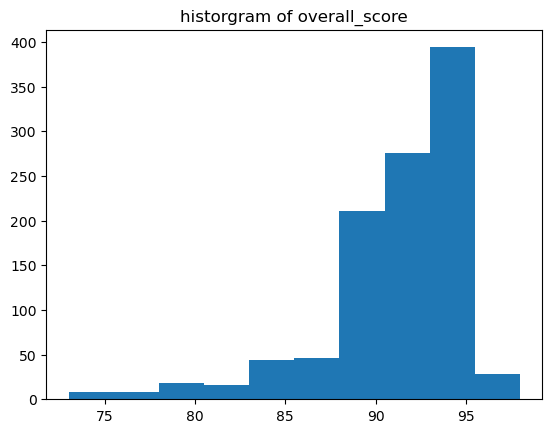

In [581]:
#plot y val distribution
plt.figure()
plt.hist(y_val)
plt.title('historgram of overall_score')
plt.show()

The test group looks a bit different but each group does have the range of values with somewhat similar distributions.

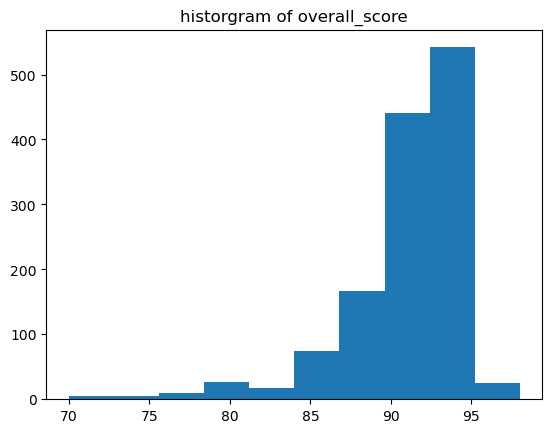

In [582]:
#plot y val distribution
plt.figure()
plt.hist(y_test)
plt.title('historgram of overall_score')
plt.show()

### Bag of Words with CountVectorizer()

`p1` Creating bag of words and graphing most popular:

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


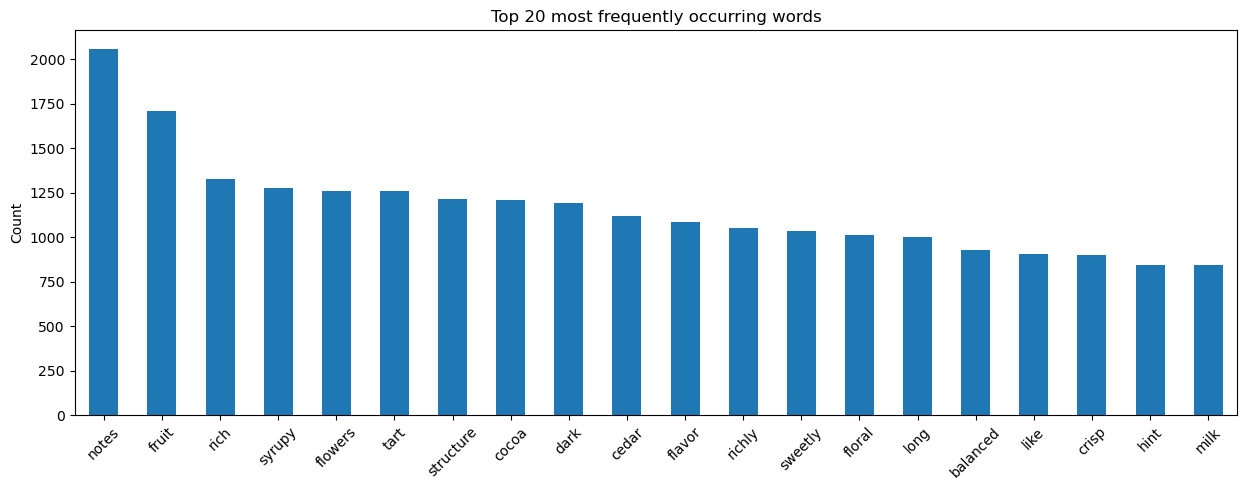

In [612]:
# 1. Instantiate 
bagofwords_p1 = CountVectorizer(stop_words='english', min_df=5, max_features=500, max_df=2000)

# 2. Fit 
bagofwords_p1.fit(X_remain["p1"])

# 3. Transform
p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
p1_val_transform = bagofwords_p1.transform(X_val["p1"])
p1_test_transform = bagofwords_p1.transform(X_test["p1"])

#the following looks at the 20 most popular words from paragraph 1

word_counts = pd.DataFrame(
    {"counts": p1_remain_transform.toarray().sum(axis=0)},
    index=bagofwords_p1.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Looking at the most popular words:

In [613]:
bagofwords_p1.get_feature_names()

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['88',
 '89',
 '90',
 '91',
 '92',
 'acid',
 'acidy',
 'admired',
 'aftertaste',
 'agave',
 'almond',
 'amber',
 'anise',
 'apple',
 'apricot',
 'aromatic',
 'aromatically',
 'aromatics',
 'astringency',
 'astringent',
 'attractive',
 'authority',
 'b70',
 'backgrounded',
 'baker',
 'baking',
 'balance',
 'balanced',
 'banana',
 'barrel',
 'bergamot',
 'berries',
 'berry',
 'best',
 'big',
 'bit',
 'bitter',
 'bitterish',
 'bitterness',
 'bittersweet',
 'black',
 'blackberry',
 'blend',
 'blood',
 'blooming',
 'blossom',
 'blueberry',
 'bodied',
 'body',
 'brandy',
 'brazil',
 'brewed',
 'brewing',
 'bright',
 'brightly',
 'brightness',
 'brisk',
 'brittle',
 'brown',
 'buoyant',
 'burned',
 'butter',
 'butterscotch',
 'buttery',
 'cacao',
 'candied',
 'candy',
 'cappuccino',
 'capsule',
 'caramel',
 'caramelly',
 'carbon',
 'cardamom',
 'carob',
 'carried',
 'carries',
 'carry',
 'carrying',
 'cashew',
 'cedar',
 'cedary',
 'center',
 'centered',
 'centers',
 'character',
 'charred',


In [614]:
#checking how many words there are
len(bagofwords_p1.get_feature_names())

500

In [615]:
# 1. Instantiate the model
p1_model = LinearRegression()

# 2. Fit the model
p1_model.fit(p1_remain_transform, y_remain)

LinearRegression()

In [616]:
# 3. Scoring the training model
print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

The R2 score for p1 CountVectorizer training data is: 0.7964119772965212
The R2 score for p1 CountVectorizer validation data is: 0.7197429002301496


`p2` Creating first bag of words with CountVectorizer and graphing:

In [ ]:
# 1. Instantiate 
bagofwords_p2 = CountVectorizer(stop_words='english', min_df=5, max_features=1000, max_df=4000)

# 2. Fit 
bagofwords_p2.fit(X_remain["p2"])

# 3. Transform
p2_remain_transform = bagofwords_p2.transform(X_remain["p2"])
p2_val_transform = bagofwords_p2.transform(X_val["p2"])
p2_test_transform = bagofwords_p2.transform(X_test["p2"])

#the following looks at the 20 most popular words from paragraph 2

word_counts = pd.DataFrame(
    {"counts": p2_remain_transform.toarray().sum(axis=0)},
    index=bagofwords_p2.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
bagofwords_p2.get_feature_names()

In [ ]:
len(bagofwords_p2.get_feature_names())

In [ ]:
# 1. Instantiate the model
p2_model = LinearRegression()

# 2. Fit the model
p2_model.fit(p2_remain_transform, y_remain)

In [ ]:
# 3. Scoring the training model
print(f'The R2 score for p2 CountVectorizor training data is: {p2_model.score(p2_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p2 CountVectorizor validation data is: {p2_model.score(p2_val_transform, y_val)}')

`p3` Creating first bag of words with CountVectorizer and graphing:

In [ ]:
# 1. Instantiate 
bagofwords_p3 = CountVectorizer(stop_words='english', min_df=5, max_df=1000, max_features=500)

# 2. Fit 
bagofwords_p3.fit(X_remain["p3"])

# 3. Transform
p3_remain_transform = bagofwords_p3.transform(X_remain["p3"])
p3_val_transform = bagofwords_p3.transform(X_val["p3"])
p3_test_transform = bagofwords_p3.transform(X_test["p3"])

#the following looks at the 20 most popular words from paragraph 3

word_counts = pd.DataFrame(
    {"counts": p3_remain_transform.toarray().sum(axis=0)},
    index=bagofwords_p3.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
bagofwords_p3.get_feature_names()

In [ ]:
len(bagofwords_p3.get_feature_names())

In [ ]:
# 1. Instantiate the model
p3_model = LinearRegression()

# 2. Fit the model
p3_model.fit(p3_remain_transform, y_remain)

In [ ]:
# 3. Scoring the training model
print(f'The R2 score for p3 CountVectorizor training data is: {p3_model.score(p3_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p3 CountVectorizor validation data is: {p3_model.score(p3_val_transform, y_val)}')

### Bag of Words with TFIDF

`p1` Tokenizing first paragraph with TFIDF and graphing:

In [ ]:
# 1. Instantiate 
tfidf_p1 = TfidfVectorizer(stop_words='english', min_df=5, max_df=1000, max_features=500)

# 2. Fit 
tfidf_p1.fit(X_remain["p1"])

# 3. Transform
tp1_remain_transform = tfidf_p1.transform(X_remain["p1"])
tp1_val_transform = tfidf_p1.transform(X_val["p1"])
tp1_test_transform = tfidf_p1.transform(X_test["p1"])

#the following looks at the 20 most popular words from paragraph 3

word_counts = pd.DataFrame(
    {"counts": tp1_remain_transform.toarray().sum(axis=0)},
    index=tfidf_p1.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
tfidf_p1.get_feature_names()

In [ ]:
len(tfidf_p1.get_feature_names())

In [ ]:
# 1. Instantiate the model
tp1_model = LinearRegression()

# 2. Fit the model
tp1_model.fit(tp1_remain_transform, y_remain)

In [ ]:
# 3. Scoring the training model
print(f'The R2 score for p1 with TFIDF training data is: {tp1_model.score(tp1_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p1 with TFIDF validation data is: {tp1_model.score(tp1_val_transform, y_val)}')

Tokenizing second paragraph with TFIDF:

In [ ]:
# 1. Instantiate 
tfidf_p2 = TfidfVectorizer(stop_words='english', min_df=5, max_df=1000, max_features=500)

# 2. Fit 
tfidf_p2.fit(X_remain["p2"])

# 3. Transform
tp2_remain_transform = tfidf_p2.transform(X_remain["p2"])
tp2_val_transform = tfidf_p2.transform(X_val["p2"])
tp2_test_transform = tfidf_p2.transform(X_test["p2"])

#the following looks at the 20 most popular words from paragraph 3

word_counts = pd.DataFrame(
    {"counts": tp2_remain_transform.toarray().sum(axis=0)},
    index=tfidf_p2.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
tfidf_p2.get_feature_names()

In [ ]:
len(tfidf_p2.get_feature_names())

In [ ]:
# 1. Instantiate the model
tp2_model = LinearRegression()

# 2. Fit the model
tp2_model.fit(tp2_remain_transform, y_remain)

In [ ]:
# 3. Scoring the training model
print(f'The R2 score for p2 TFIDF training data is: {tp2_model.score(tp2_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p2 TFIDF validation data is: {tp2_model.score(tp2_val_transform, y_val)}')

Tokenizing 3rd paragraph with TFIDF:

In [ ]:
# 1. Instantiate 
tfidf_p3 = TfidfVectorizer(stop_words='english', min_df=5, max_df=1000, max_features=500)

# 2. Fit 
tfidf_p3.fit(X_remain["p3"])

# 3. Transform
tp3_remain_transform = tfidf_p3.transform(X_remain["p3"])
tp3_val_transform = tfidf_p3.transform(X_val["p3"])
tp3_test_transform = tfidf_p3.transform(X_test["p3"])

#the following looks at the 20 most popular words from paragraph 3

word_counts = pd.DataFrame(
    {"counts": tp3_remain_transform.toarray().sum(axis=0)},
    index=tfidf_p3.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
tfidf_p3.get_feature_names()

In [ ]:
len(tfidf_p3.get_feature_names())

In [ ]:
# 1. Instantiate the model
tp3_model = LinearRegression()

# 2. Fit the model
tp3_model.fit(tp3_remain_transform, y_remain)

In [ ]:
# 3. Scoring the training model
print(f'The R2 score for p3 TFIDF training data is: {tp3_model.score(tp3_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p3 TFIDF validation data is: {tp3_model.score(tp3_val_transform, y_val)}')

Comparing scores:

### Exploring different ranges for  vectorizing values

IMPORTANT: For now, just exploring these one piece at time to get sense of how well these vectorizers can perform. Later, need to fine-tune considering how changes interact with each other.

Exploring impact of changing min_df:

In [622]:
for i in range(1,30,2):

    bagofwords_p1 = CountVectorizer(stop_words='english', min_df=i, max_features=500, max_df=2000)

    bagofwords_p1.fit(X_remain["p1"])

    p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
    p1_val_transform = bagofwords_p1.transform(X_val["p1"])
    p1_test_transform = bagofwords_p1.transform(X_test["p1"])

    p1_model = LinearRegression()

    p1_model.fit(p1_remain_transform, y_remain)

    print(f'min_df: {i}')
    print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')
    print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

min_df: 1
The R2 score for p1 CountVectorizer training data is: 0.7971293101525744
The R2 score for p1 CountVectorizer validation data is: 0.7198875272862395
min_df: 3
The R2 score for p1 CountVectorizer training data is: 0.7968008296848125
The R2 score for p1 CountVectorizer validation data is: 0.7188545408195172
min_df: 5
The R2 score for p1 CountVectorizer training data is: 0.7964119772965212
The R2 score for p1 CountVectorizer validation data is: 0.7197429002301496
min_df: 7
The R2 score for p1 CountVectorizer training data is: 0.7971311350334999
The R2 score for p1 CountVectorizer validation data is: 0.7188114739184971
min_df: 9
The R2 score for p1 CountVectorizer training data is: 0.7969340609841649
The R2 score for p1 CountVectorizer validation data is: 0.7192618354927407
min_df: 11
The R2 score for p1 CountVectorizer training data is: 0.796882188399935
The R2 score for p1 CountVectorizer validation data is: 0.719423570984257
min_df: 13
The R2 score for p1 CountVectorizer traini

Min_df below 25 seems best.

Experimenting with best max_feature range:

In [631]:
for i in range(100,1000,50):

    bagofwords_p1 = CountVectorizer(stop_words='english', min_df=1, max_features=i, max_df=2000)

    bagofwords_p1.fit(X_remain["p1"])

    p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
    p1_val_transform = bagofwords_p1.transform(X_val["p1"])
    p1_test_transform = bagofwords_p1.transform(X_test["p1"])

    p1_model = LinearRegression()

    p1_model.fit(p1_remain_transform, y_remain)

    print(f'max_features: {i}')
    print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')
    print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

max_features: 100
The R2 score for p1 CountVectorizer training data is: 0.5856413450135611
The R2 score for p1 CountVectorizer validation data is: 0.5526252013505311
max_features: 150
The R2 score for p1 CountVectorizer training data is: 0.6171798282273036
The R2 score for p1 CountVectorizer validation data is: 0.5855458279587475
max_features: 200
The R2 score for p1 CountVectorizer training data is: 0.6514908643415833
The R2 score for p1 CountVectorizer validation data is: 0.6200462226736527
max_features: 250
The R2 score for p1 CountVectorizer training data is: 0.6692036944671249
The R2 score for p1 CountVectorizer validation data is: 0.6406954715553743
max_features: 300
The R2 score for p1 CountVectorizer training data is: 0.6903116761785397
The R2 score for p1 CountVectorizer validation data is: 0.6502268264373402
max_features: 350
The R2 score for p1 CountVectorizer training data is: 0.7341964141733877
The R2 score for p1 CountVectorizer validation data is: 0.7044779907741969
max_

Lower number of max_features seems to matter a lot for validation data. Peak number around 550.

In [633]:
for i in range(100,20000,1000):

    bagofwords_p1 = CountVectorizer(stop_words='english', min_df=1, max_features=550, max_df=i)

    bagofwords_p1.fit(X_remain["p1"])

    p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
    p1_val_transform = bagofwords_p1.transform(X_val["p1"])
    p1_test_transform = bagofwords_p1.transform(X_test["p1"])

    p1_model = LinearRegression()

    p1_model.fit(p1_remain_transform, y_remain)

    print(f'max_df: {i}')
    print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')
    print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

max_df: 100
The R2 score for p1 CountVectorizer training data is: 0.7289935687968977
The R2 score for p1 CountVectorizer validation data is: 0.5279570458747466
max_df: 1100
The R2 score for p1 CountVectorizer training data is: 0.7976030784326417
The R2 score for p1 CountVectorizer validation data is: 0.7103999410467023
max_df: 2100
The R2 score for p1 CountVectorizer training data is: 0.8066403645618548
The R2 score for p1 CountVectorizer validation data is: 0.7228159230797606
max_df: 3100
The R2 score for p1 CountVectorizer training data is: 0.8109076309998833
The R2 score for p1 CountVectorizer validation data is: 0.7322565210667109
max_df: 4100
The R2 score for p1 CountVectorizer training data is: 0.8158418605910207
The R2 score for p1 CountVectorizer validation data is: 0.7409300107606831
max_df: 5100
The R2 score for p1 CountVectorizer training data is: 0.8158418605910207
The R2 score for p1 CountVectorizer validation data is: 0.7409300107606831
max_df: 6100
The R2 score for p1 Co

Stops improving around 4100. 

Testing with these parameters:

In [635]:
bagofwords_p1 = CountVectorizer(stop_words='english', min_df=1, max_features=550, max_df=4500)

bagofwords_p1.fit(X_remain["p1"])

p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
p1_val_transform = bagofwords_p1.transform(X_val["p1"])
p1_test_transform = bagofwords_p1.transform(X_test["p1"])

p1_model = LinearRegression()

p1_model.fit(p1_remain_transform, y_remain)

print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')
print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

The R2 score for p1 CountVectorizer training data is: 0.8158418605910207
The R2 score for p1 CountVectorizer validation data is: 0.7409300107606831


Doing similar thing with TFIDF:

In [640]:
for i in range(1,30,2):
    
    tfidf_p1 = TfidfVectorizer(stop_words='english', min_df=i, max_df=1000, max_features=500)

    tfidf_p1.fit(X_remain["p1"])

    tp1_remain_transform = tfidf_p1.transform(X_remain["p1"])
    tp1_val_transform = tfidf_p1.transform(X_val["p1"])
    tp1_test_transform = tfidf_p1.transform(X_test["p1"])

    tp1_model = LinearRegression()

    tp1_model.fit(tp1_remain_transform, y_remain)

    print(f'min_df value: {i}')
    print(f'The R2 score for p3 TFIDF training data is: {tp1_model.score(tp1_remain_transform, y_remain)}')
    print(f'The R2 score for p3 TFIDF validation data is: {tp1_model.score(tp1_val_transform, y_val)}')

min_df value: 1
The R2 score for p3 TFIDF training data is: 0.81592625225169
The R2 score for p3 TFIDF validation data is: 0.7381128517073058
min_df value: 3
The R2 score for p3 TFIDF training data is: 0.8154911834921937
The R2 score for p3 TFIDF validation data is: 0.7357066420810723
min_df value: 5
The R2 score for p3 TFIDF training data is: 0.8151958947450861
The R2 score for p3 TFIDF validation data is: 0.7372001258517663
min_df value: 7
The R2 score for p3 TFIDF training data is: 0.8154377265842551
The R2 score for p3 TFIDF validation data is: 0.7360781773530345
min_df value: 9
The R2 score for p3 TFIDF training data is: 0.8154674556488584
The R2 score for p3 TFIDF validation data is: 0.7376929364771404
min_df value: 11
The R2 score for p3 TFIDF training data is: 0.815511214837542
The R2 score for p3 TFIDF validation data is: 0.7372749979752773
min_df value: 13
The R2 score for p3 TFIDF training data is: 0.8155395099602923
The R2 score for p3 TFIDF validation data is: 0.7356988662

This one also seems to do better with lower min_df value.

Experimenting with max_features:

In [642]:
for i in range(1,1000,100):
    
    tfidf_p1 = TfidfVectorizer(stop_words='english', min_df=1, max_features=i, max_df=1000)

    tfidf_p1.fit(X_remain["p1"])

    tp1_remain_transform = tfidf_p1.transform(X_remain["p1"])
    tp1_val_transform = tfidf_p1.transform(X_val["p1"])
    tp1_test_transform = tfidf_p1.transform(X_test["p1"])

    tp1_model = LinearRegression()

    tp1_model.fit(tp1_remain_transform, y_remain)

    print(f'max_features value: {i}')
    print(f'The R2 score for p3 TFIDF training data is: {tp1_model.score(tp1_remain_transform, y_remain)}')
    print(f'The R2 score for p3 TFIDF validation data is: {tp1_model.score(tp1_val_transform, y_val)}')

max_features value: 1
The R2 score for p3 TFIDF training data is: 0.025146583223369712
The R2 score for p3 TFIDF validation data is: 0.014159491772634758
max_features value: 101
The R2 score for p3 TFIDF training data is: 0.6255532485254598
The R2 score for p3 TFIDF validation data is: 0.5947609919363476
max_features value: 201
The R2 score for p3 TFIDF training data is: 0.6882654682145494
The R2 score for p3 TFIDF validation data is: 0.6549450235502456
max_features value: 301
The R2 score for p3 TFIDF training data is: 0.7318341071054175
The R2 score for p3 TFIDF validation data is: 0.6886396025167947
max_features value: 401
The R2 score for p3 TFIDF training data is: 0.7856603416209352
The R2 score for p3 TFIDF validation data is: 0.7291414109443438
max_features value: 501
The R2 score for p3 TFIDF training data is: 0.816067529189566
The R2 score for p3 TFIDF validation data is: 0.7375991423920538
max_features value: 601
The R2 score for p3 TFIDF training data is: 0.8324275365060032


This one also seems to peak around 500.

Exploring max_df:

In [643]:
for i in range(1000,10000,500):
    
    tfidf_p1 = TfidfVectorizer(stop_words='english', min_df=1, max_features=550, max_df=i)

    tfidf_p1.fit(X_remain["p1"])

    tp1_remain_transform = tfidf_p1.transform(X_remain["p1"])
    tp1_val_transform = tfidf_p1.transform(X_val["p1"])
    tp1_test_transform = tfidf_p1.transform(X_test["p1"])

    tp1_model = LinearRegression()

    tp1_model.fit(tp1_remain_transform, y_remain)

    print(f'max_df value: {i}')
    print(f'The R2 score for p3 TFIDF training data is: {tp1_model.score(tp1_remain_transform, y_remain)}')
    print(f'The R2 score for p3 TFIDF validation data is: {tp1_model.score(tp1_val_transform, y_val)}')

max_df value: 1000
The R2 score for p3 TFIDF training data is: 0.8248144084175266
The R2 score for p3 TFIDF validation data is: 0.7370180742269337
max_df value: 1500
The R2 score for p3 TFIDF training data is: 0.8322591664386849
The R2 score for p3 TFIDF validation data is: 0.749357811282411
max_df value: 2000
The R2 score for p3 TFIDF training data is: 0.8313197625120955
The R2 score for p3 TFIDF validation data is: 0.7518167676229126
max_df value: 2500
The R2 score for p3 TFIDF training data is: 0.8345954199916161
The R2 score for p3 TFIDF validation data is: 0.7526934447614977
max_df value: 3000
The R2 score for p3 TFIDF training data is: 0.835018896921154
The R2 score for p3 TFIDF validation data is: 0.7564003124161833
max_df value: 3500
The R2 score for p3 TFIDF training data is: 0.8353937842654713
The R2 score for p3 TFIDF validation data is: 0.7582774282953104
max_df value: 4000
The R2 score for p3 TFIDF training data is: 0.8367144278133779
The R2 score for p3 TFIDF validation d

This one seems to peak around 4000.

Comparing best versions:

In [644]:
bagofwords_p1 = CountVectorizer(stop_words='english', min_df=1, max_features=550, max_df=4500)

bagofwords_p1.fit(X_remain["p1"])

p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
p1_val_transform = bagofwords_p1.transform(X_val["p1"])
p1_test_transform = bagofwords_p1.transform(X_test["p1"])

p1_model = LinearRegression()

p1_model.fit(p1_remain_transform, y_remain)

print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')
print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

The R2 score for p1 CountVectorizer training data is: 0.8158418605910207
The R2 score for p1 CountVectorizer validation data is: 0.7409300107606831


In [647]:
tfidf_p1 = TfidfVectorizer(stop_words='english', min_df=1, max_features=550, max_df=4500)

tfidf_p1.fit(X_remain["p1"])

tp1_remain_transform = tfidf_p1.transform(X_remain["p1"])
tp1_val_transform = tfidf_p1.transform(X_val["p1"])
tp1_test_transform = tfidf_p1.transform(X_test["p1"])

tp1_model = LinearRegression()

tp1_model.fit(tp1_remain_transform, y_remain)

print(f'The R2 score for p3 TFIDF training data is: {tp1_model.score(tp1_remain_transform, y_remain)}')
print(f'The R2 score for p3 TFIDF validation data is: {tp1_model.score(tp1_val_transform, y_val)}')

The R2 score for p3 TFIDF training data is: 0.8367144278133779
The R2 score for p3 TFIDF validation data is: 0.7618058245152186


Between the two, the tfidf does slightly better on these initial test runs.